In [6]:
import os
import pandas as pd
import io
import unicodedata

root_dir = 'coral_and_sponges_all/data/pub/data/paleo/coral'


In [7]:
root_files = os.listdir(root_dir)
root_files = root_files[0:3] + root_files[4:6] + root_files[9:12]
sub_files_to_flatten = [[f'{r}/{f}' for f in os.listdir(f'{root_dir}/{r}')] for r in root_files]
#Flatten list of files into one list
sub_files = [f'{root_dir}/{item}' for sublist in sub_files_to_flatten for item in sublist]

In [8]:
len(sub_files)

179

In [9]:
def create_coral_file_df(filename):
    try:
        # Using a weird encoding to solve file read issue; see https://stackoverflow.com/questions/46000191/utf-8-codec-cant-decode-byte-0x92-in-position-18-invalid-start-byte
        coral_file = open(filename,'r', encoding="cp1252")
        file_in = coral_file.readlines()

        for i in range(len(file_in)):
            line = file_in[i]
            #print(line)
            if "Location:" in line:
                location = line.split(": ")[1].strip()
            if "Northernmost_Latitude:" in line:
                northernmost_lat = line.split(": ")[1].strip()
            if "Southernmost_Latitude:" in line:
                southernmost_lat = line.split(": ")[1].strip()
            if "Easternmost_Longitude:" in line:
                easternmost_lat = line.split(": ")[1].strip()
            if "Westernmost_Longitude:" in line:
                westernmost_lat = line.split(": ")[1].strip()
            if "Elevation:" in line:
                elevation = line.split(": ")[1].split(' ')[0].strip()
            if "Earliest_Year:" in line:
                earliest_year = line.split(": ")[1].strip()
            if "Most_Recent_Year:" in line:
                most_recent_year = line.split(": ")[1].strip()
            if "Species_Name:" in line:
                species = line.split(": ")[1].strip('\n').strip()
            if not line.startswith('#'):
                if line.startswith('ï»¿#'):
                    continue #this is the first line with special characters hidden
                elif len(line.strip()) == 0:
                    continue
                else:
                    age_line = i
                    extracted = ' '.join(file_in[age_line:])
                    break #exit the for loop, we have obtained the data!

        lat = (float(northernmost_lat) + float(southernmost_lat)) / 2
        lon = (float(easternmost_lat) + float(westernmost_lat)) / 2

        data = io.StringIO(extracted)
        df = pd.read_csv(data, sep="\t", error_bad_lines=False)

        df.columns = (map(lambda x: x.lower(), df.columns))

        # find the correct 'age' column
        if 'age' not in df.columns:
            if 'age_ad' in df.columns:
                df['age'] = df['age_ad']
            elif 'age_calad' in df.columns:
                df['age'] = df['age_ad']
            elif 'time' in df.columns:
                df['age'] = df['time']
            elif 'date' in df.columns:
                df['age'] = df['date']
            elif 'year' in df.columns:
                df['age'] = df['year']
            elif 'year_ce' in df.columns:
                df['age'] = df['year_ce']
            else:
                print("No 'age' column header detected.")

        #print(df['age'])

        #find the correct d18O column
        if 'd18o' not in df.columns:
            count = 0
            for col in df.columns:
                # we are assuming that the first col with d18O is the one we want
                if 'd18o' in col:
                    if 'recon' in col:
                        continue
                    df['d18o'] = df[col]
                    break
        
        #print(df['d18o'])

        df = df[['age', 'd18o']]
        df = df[df['d18o'] != 'NAN']

        # average the d18O values across the years
        df['year']  = df['age'].apply(lambda x: str(x).strip()[0:4])
        df = df.groupby(by="year")["d18o"].mean().reset_index('year')

        df['lat'] = lat
        df['lon'] = lon
        df['elevation'] = elevation
        
        try:
            species
            df['species'] = species
        except NameError:
            df['species'] = 'Other'

        return(df)

        # except Exception as e:
        #     print("exception2")
        #     print("ERROR : "+str(e))
        #     # print("Error on line {}".format(sys.exc_info()[-1].tb_lineno))
            # print('hi')
    except Exception as e:
        print("ERROR : "+str(e))

Quick Proof of Concept for the function above:

In [10]:
#filename = f'{root_dir}/atlantic/barbados_coral18o.txt'
# filename = f'{root_dir}/atlantic/goodkin2008-sst_noaa.txt'
# filename = f'{root_dir}/atlantic/smith2006-lk1.txt'
filename = f'{root_dir}/red_sea/felis2000_noaa.txt'
#'swart1998-st-1_noaa.txt'

create_coral_file_df(filename)

/var/folders/ws/d7dc4bz53q3_26hs2vbmg8600000gn/T/ipykernel_29861/2746504789.py:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  create_coral_file_df(filename)


,year,d18o,lat,lon,elevation,species
0,1751,-3.210000,27.85,34.32,-6,Porites sp.
1,1752,-3.250000,27.85,34.32,-6,Porites sp.
2,1753,-3.236667,27.85,34.32,-6,Porites sp.
3,1754,-3.228333,27.85,34.32,-6,Porites sp.
4,1755,-2.990000,27.85,34.32,-6,Porites sp.
...,...,...,...,...,...,...
240,1991,-3.461667,27.85,34.32,-6,Porites sp.
241,1992,-3.421667,27.85,34.32,-6,Porites sp.
242,1993,-3.523333,27.85,34.32,-6,Porites sp.
243,1994,-3.588333,27.85,34.32,-6,Porites sp.


In [20]:
#fn = "coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/zinke2012-mas3-iso.txt"
fn = "coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/kuhnert2000-depth_noaa.txt"
create_coral_file_df(fn)

/var/folders/ws/d7dc4bz53q3_26hs2vbmg8600000gn/T/ipykernel_14845/430163200.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  create_coral_file_df(fn)


,year,d18o,lat,lon,elevation,species
0,1878,-4.265000,-21.905,113.965,-3,Porites lutea
1,1879,-4.648333,-21.905,113.965,-3,Porites lutea
2,1880,-4.628000,-21.905,113.965,-3,Porites lutea
3,1881,-4.551667,-21.905,113.965,-3,Porites lutea
4,1882,-4.310000,-21.905,113.965,-3,Porites lutea
...,...,...,...,...,...,...
114,1992,-4.728333,-21.905,113.965,-3,Porites lutea
115,1993,-4.522000,-21.905,113.965,-3,Porites lutea
116,1994,-4.736000,-21.905,113.965,-3,Porites lutea
117,1995,-4.870000,-21.905,113.965,-3,Porites lutea


In [19]:
all_coral_df = pd.DataFrame(columns=['age', 'd18O', 'lat', 'lon', 'elevation', 'species'])
for file in sub_files:
    print(file)
    coral_df = create_coral_file_df(file)
    try:
        all_coral_df = pd.concat([all_coral_df, coral_df])
    except Exception as e:
        print('Error: ' + str(e))

del all_coral_df['age']
del all_coral_df['d18O']

all_coral_df.reset_index
all_coral_df


coral_and_sponges_all/data/pub/data/paleo/coral/atlantic/moses2006-side_noaa.txt
ERROR : local variable 'northernmost_lat' referenced before assignment
coral_and_sponges_all/data/pub/data/paleo/coral/atlantic/goodkin2008-sst_noaa.txt
ERROR : local variable 'northernmost_lat' referenced before assignment
coral_and_sponges_all/data/pub/data/paleo/coral/atlantic/kuhnert2002_noaa.txt
ERROR : local variable 'northernmost_lat' referenced before assignment
coral_and_sponges_all/data/pub/data/paleo/coral/atlantic/moses2006_noaa.txt
coral_and_sponges_all/data/pub/data/paleo/coral/atlantic/moses2006-fave_noaa.txt
coral_and_sponges_all/data/pub/data/paleo/coral/atlantic/smith2006-lk1.txt
coral_and_sponges_all/data/pub/data/paleo/coral/atlantic/swart1999-fb-5_noaa.txt
coral_and_sponges_all/data/pub/data/paleo/coral/atlantic/barbados_coral18o.txt
ERROR : local variable 'northernmost_lat' referenced before assignment
coral_and_sponges_all/data/pub/data/paleo/coral/atlantic/swart1998-st-1_noaa.txt
co

/var/folders/ws/d7dc4bz53q3_26hs2vbmg8600000gn/T/ipykernel_14845/1366428.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  coral_df = create_coral_file_df(file)


coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/zinke2014-sr-ifaty1.txt
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/zinke2012-mas3-iso.txt
No 'age' column header detected.
ERROR : "['age'] not in index"
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/zinke2014-sr
ERROR : [Errno 21] Is a directory: 'coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/zinke2014-sr'
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/damassa2006-new_noaa.txt
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/hennekam2018-dl-d18o.txt
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/kuhnert1999-bimonth_noaa.txt
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/zinke2014-sr-tulear3.txt
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/hennekam2018-d3-d18o.txt
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/zinke2014-sr-ifaty4.txt
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/ku

b'Skipping line 1419: expected 3 fields, saw 4\n'


coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/wei2009_noaa.txt
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/ramos2019-month.txt
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/brenner2017-her.txt
No 'age' column header detected.
ERROR : "['age'] not in index"
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/kilbourne2004_noaa.txt
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/palau2013ngb.txt
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/linsley2006-1f.txt
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/palau2002.txt
ERROR : local variable 'northernmost_lat' referenced before assignment
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/palau2014uc.txt
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/linsley2006
ERROR : [Errno 21] Is a directory: 'coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/linsley2006'
coral_and_sponges_all/data/pub/data/paleo/coral/

,lat,lon,elevation,species,year,d18o
0,16.77,-22.88,-3,Siderastrea radians,1928,-3.110000
1,16.77,-22.88,-3,Siderastrea radians,1929,-3.008333
2,16.77,-22.88,-3,Siderastrea radians,1930,-2.835000
3,16.77,-22.88,-3,Siderastrea radians,1931,-2.855833
4,16.77,-22.88,-3,Siderastrea radians,1932,-2.936667
...,...,...,...,...,...,...
2,9.83,115.50,-5,Other,1998,-5.974038
3,9.83,115.50,-5,Other,1999,-5.802692
4,9.83,115.50,-5,Other,2000,-5.867736
5,9.83,115.50,-5,Other,2001,-5.959808


In [109]:
all_coral_df.to_csv('all_coral.csv')


In [14]:
all_coral_df

,lat,lon,elevation,species,year,d18o
0,16.77,-22.88,-3,Siderastrea radians,1928,-3.110000
1,16.77,-22.88,-3,Siderastrea radians,1929,-3.008333
2,16.77,-22.88,-3,Siderastrea radians,1930,-2.835000
3,16.77,-22.88,-3,Siderastrea radians,1931,-2.855833
4,16.77,-22.88,-3,Siderastrea radians,1932,-2.936667
...,...,...,...,...,...,...
2,9.83,115.50,-5,Other,1998,-5.974038
3,9.83,115.50,-5,Other,1999,-5.802692
4,9.83,115.50,-5,Other,2000,-5.867736
5,9.83,115.50,-5,Other,2001,-5.959808


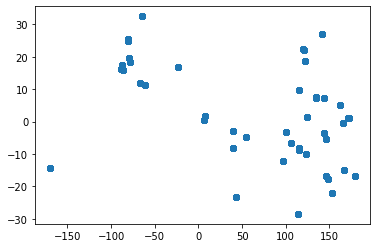

In [22]:
import matplotlib.pyplot as plt
plt.scatter(all_coral_df['lon'], all_coral_df['lat'])


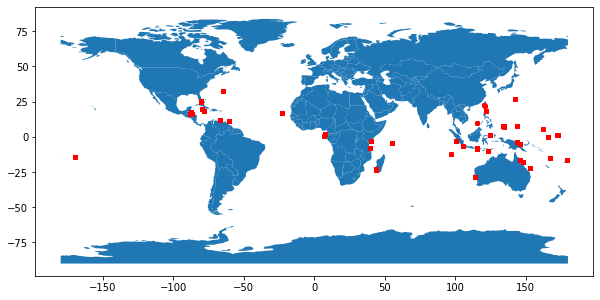

In [25]:
import shapely
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(all_coral_df['lon'], 
                                    all_coral_df['lat'])]

gdf = GeoDataFrame(all_coral_df, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Looking at the lat/lon of our data, it looks like we will have a model heavily biased towards the western part of this map, and in tropical regions.

In [13]:
coral_file = 'swart1998-st-1_noaa.txt'
# Example of file with -noaa extension
file1 = open(coral_file,'r')
print(file1.read())
file1.close()

﻿# Gulf of Guinea Coral Isotope, Luminescence and Density Data
#----------------------------------------------------------------------- 
#                World Data Center for Paleoclimatology, Boulder 
#                                  and 
#                     NOAA Paleoclimatology Program 
#----------------------------------------------------------------------- 
# NOTE: Please cite Publication, and Online_Resource and date accessed when using these data. 
# If there is no publication information, please cite Investigators, Title, and Online_Resource and date accessed. 
#
# Online_Resource: https://www.ncdc.noaa.gov/study/1913
#
# Original_Source_URL: http://www1.ncdc.noaa.gov/pub/data/paleo/coral/atlantic/saotome1998.txt
# 
# Description/Documentation lines begin with #
# Data lines have no #
#
# Archive: Corals and Sclerosponges
#--------------------
# Contribution_Date
#	Date: 2005-02-01
#--------------------
# Title
#	Study_Name: Ponta Banana, Principe, Sao Tome - Isotope, Lumi

Gather metadata info! (site lat/lon & years of study)

In [ ]:
file1 = open(coral_file,'r')
file_in = file1.readlines()

for line in file_in:
    if "Location:" in line:
        location = line.split(": ")[1]
    if "Northernmost_Latitude:" in line:
        northernmost_lat = line.split(": ")[1]
    if "Southernmost_Latitude:" in line:
        southernmost_lat = line.split(": ")[1]
    if "Easternmost_Longitude:" in line:
        easternmost_lat = line.split(": ")[1]
    if "Westernmost_Longitude:" in line:
        westernmost_lat = line.split(": ")[1]
    if "Elevation:" in line:
        elevation = line.split(": ")[1].split(' ')[0]
    if "Earliest_Year:" in line:
        earliest_year = line.split(": ")[1]
    if "Most_Recent_Year:" in line:
        most_recent_year = line.split(": ")[1]
    if "Species_Name:" in line:
        species = line.split(": ")[1].strip('\n')

lat = (float(northernmost_lat) + float(southernmost_lat)) / 2
lon = (float(easternmost_lat) + float(westernmost_lat)) / 2



In [ ]:
age_line = 0
file1 = open(coral_file,'r')
with file1 as f:
    lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith('age'):
            print(i)
            age_line = i
            break
    extracted = ' '.join(lines[age_line:])
    print(extracted)

In [ ]:
data = io.StringIO(extracted)
df_test = pd.read_csv(data, sep="\t")
df_test.head()

Just grab `age` and `d18O` columns! And remove NAN values. 

In [ ]:
df_test_d18O = df_test[['age', 'd18O']]
df_test_d18O = df_test_d18O[df_test_d18O['d18O'] != 'NAN']
df_test_d18O['lat'] = lat
df_test_d18O['lon'] = lon
df_test_d18O['elevation'] = elevation
df_test_d18O['species'] = species
df_test_d18O